In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install required packages
!pip install sentence-transformers torch transformers scikit-learn pandas openpyxl matplotlib seaborn tqdm scipy


In [ ]:
import warnings
# from google.colab import drive
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import json
import random
import time
from tqdm import tqdm
import itertools
import os
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import string
import re
from typing import List, Tuple, Dict
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel, BertModel, BertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import torch

warnings.filterwarnings('ignore')

# # Mount Google Drive
# print("Mounting Google Drive...")
# drive.mount('/content/drive')

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(
        f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


In [ ]:
class CrossLingualSimilarityModel:
    """
    Implementation of cross-lingual sentence similarity using dual-encoder architecture
    following Feng et al. (2022) methodology with GPU optimization
    """

    def __init__(self, model_name: str = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"):
        """
        Initialize the cross-lingual similarity model with GPU support

        Args:
            model_name: Pre-trained sentence transformer model name
        """
        print(f"Initializing model: {model_name}")
        print(f"Loading on device: {device}")

        # Step 1: Setup Dual-Encoder Architecture with GPU
        self.model = SentenceTransformer(model_name, device=device)
        self.tokenizer = self.model.tokenizer

        # Algorithm parameters from Feng et al. (2022)
        self.max_seq_length = 128  # Maximum sequence length
        self.embedding_dim = 384   # Updated for MiniLM model
        self.similarity_threshold = 0.7  # High similarity threshold
        self.scale_factor = 10     # Scaling factor for embeddings

        print(f"✅ Model loaded successfully on {device}")
        print(f"Embedding dimension: {self.embedding_dim}")

    def preprocess_text(self, text: str) -> str:
        """
        Inference Phase - Step 1: Preprocess input texts
        Tokenize input texts (max len 128; lowercase, remove punctuation)

        Args:
            text: Input text to preprocess

        Returns:
            Preprocessed text
        """
        # Handle NaN or None values
        if pd.isna(text) or text is None:
            return ""

        # Convert to string if not already
        text = str(text)

        # Convert to lowercase as specified in algorithm
        text = text.lower()

        # Remove punctuation (keeping spaces and basic structure)
        text = re.sub(r'[^\w\s]', '', text)

        # Remove extra whitespaces
        text = ' '.join(text.split())

        return text

    def encode_sentences(self, sentences: List[str], batch_size: int = 32) -> np.ndarray:
        """
        Inference Phase - Step 2: Encode sentences with GPU optimization
        Forward each text through encoder; extract normalized [CLS] embedding

        Args:
            sentences: List of sentences to encode
            batch_size: Batch size for GPU processing

        Returns:
            Normalized embeddings array of shape (n_sentences, embedding_dim)
        """
        # Preprocess all sentences
        preprocessed = [self.preprocess_text(sent) for sent in sentences]

        # Filter out empty sentences
        valid_sentences = [sent for sent in preprocessed if sent.strip()]
        if not valid_sentences:
            return np.array([]).reshape(0, self.embedding_dim)

        # Forward pass through the dual-encoder with GPU acceleration
        embeddings = self.model.encode(
            valid_sentences,
            convert_to_numpy=True,
            normalize_embeddings=True,  # L2-normalize as in algorithm
            batch_size=batch_size,
            show_progress_bar=False,
            device=device
        )

        # Scale by factor of 10 as specified in the algorithm
        embeddings = embeddings * self.scale_factor

        return embeddings

    def compute_similarity(self, text1: str, text2: str) -> float:
        """
        Inference Phase - Step 3: Compute Similarity
        For embeddings e1, e2: cos(θ) = e1^T * e2 (range -1 to 1)

        Args:
            text1: First text for comparison
            text2: Second text for comparison

        Returns:
            Cosine similarity score between -1 and 1
        """
        # Handle empty or invalid inputs
        if not text1 or not text2 or pd.isna(text1) or pd.isna(text2):
            return 0.0

        # Encode both sentences
        embeddings = self.encode_sentences([text1, text2])

        if embeddings.shape[0] < 2:
            return 0.0

        e1, e2 = embeddings[0], embeddings[1]

        # Compute cosine similarity: cos(θ) = e1^T * e2
        similarity = np.dot(e1, e2)

        return float(similarity)

    def batch_similarity_matrix(self, texts1: List[str], texts2: List[str], batch_size: int = 64) -> np.ndarray:
        """
        Compute similarity matrix for two sets of texts with GPU optimization

        Args:
            texts1: First set of texts
            texts2: Second set of texts
            batch_size: Batch size for GPU processing

        Returns:
            Similarity matrix of shape (len(texts1), len(texts2))
        """
        # Encode all texts from both sets with larger batch size for GPU
        embeddings1 = self.encode_sentences(texts1, batch_size=batch_size)
        embeddings2 = self.encode_sentences(texts2, batch_size=batch_size)

        if embeddings1.shape[0] == 0 or embeddings2.shape[0] == 0:
            return np.array([]).reshape(len(texts1), len(texts2))

        # Compute cosine similarity matrix
        similarity_matrix = cosine_similarity(embeddings1, embeddings2)

        return similarity_matrix

    def interpret_similarity(self, similarity_score: float) -> Dict[str, any]:
        """
        Inference Phase - Step 4: Interpret similarity scores with precise analysis
        """
        # Normalize score to 0-1 range for interpretation
        normalized_score = (similarity_score + 1) / 2

        # Define precise interpretation thresholds based on STS benchmarks
        if similarity_score > 0.9:
            interpretation = "Extremely High Similarity"
            confidence = "Very High"
            description = "Near-identical semantic meaning"
            relationship = "Equivalent/Paraphrases"
        elif similarity_score > 0.8:
            interpretation = "Very High Similarity"
            confidence = "High"
            description = "Strong semantic overlap with minor differences"
            relationship = "Highly Related/Similar Topics"
        elif similarity_score > 0.7:
            interpretation = "High Similarity"  # As specified in algorithm
            confidence = "High"
            description = "Significant semantic similarity"
            relationship = "Related Content/Shared Themes"
        elif similarity_score > 0.6:
            interpretation = "Moderate-High Similarity"
            confidence = "Medium-High"
            description = "Noticeable semantic connection"
            relationship = "Somewhat Related/Common Elements"
        elif similarity_score > 0.5:
            interpretation = "Moderate Similarity"
            confidence = "Medium"
            description = "Some semantic overlap"
            relationship = "Loosely Related/Few Common Elements"
        elif similarity_score > 0.4:
            interpretation = "Moderate-Low Similarity"
            confidence = "Medium"
            description = "Weak semantic connection"
            relationship = "Minimally Related/Different Topics"
        elif similarity_score > 0.3:
            interpretation = "Low Similarity"
            confidence = "Medium"
            description = "Little semantic overlap"
            relationship = "Barely Related/Distinct Topics"
        elif similarity_score > 0.1:
            interpretation = "Very Low Similarity"
            confidence = "High"
            description = "Minimal semantic connection"
            relationship = "Unrelated/Different Domains"
        else:
            interpretation = "No Meaningful Similarity"
            confidence = "Very High"
            description = "No detectable semantic relationship"
            relationship = "Completely Unrelated/Opposite"

        return {
            "raw_score": similarity_score,
            "normalized_score": normalized_score,
            "interpretation": interpretation,
            "confidence": confidence,
            "description": description,
            "relationship": relationship,
            "above_threshold": similarity_score > self.similarity_threshold,
        }

In [ ]:
def load_data_files():
    """
    Load data from manual.csv and naijahate.xlsx from Google Drive

    Returns:
        Tuple of (manual_df, hate_speech_df)
    """
    try:
        # Define file paths in Google Drive
        manual_path = "/content/drive/MyDrive/Colab Notebooks/similar_test/manual.csv"
        hate_speech_path = "/content/drive/MyDrive/Colab Notebooks/similar_test/naijahate.xlsx"

        manual_df = None
        hate_speech_df = None

        # Load manual.csv
        if os.path.exists(manual_path):
            manual_df = pd.read_csv(manual_path)
            print(f"✅ Loaded manual.csv with {len(manual_df)} rows")
            print(f"   Columns: {list(manual_df.columns)}")
        else:
            print(f"❌ manual.csv not found at {manual_path}")

        # Load naijahate.xlsx
        if os.path.exists(hate_speech_path):
            hate_speech_df = pd.read_excel(hate_speech_path)
            print(f"✅ Loaded naijahate.xlsx with {len(hate_speech_df)} rows")
            print(f"   Columns: {list(hate_speech_df.columns)}")
        else:
            print(f"❌ naijahate.xlsx not found at {hate_speech_path}")

        return manual_df, hate_speech_df

    except Exception as e:
        print(f"❌ Error loading data files: {e}")
        return None, None

In [ ]:
def extract_all_texts(df, dataset_name):
    """
    Extract all text data from a DataFrame

    Args:
        df: DataFrame to extract text from
        dataset_name: Name of the dataset for logging

    Returns:
        List of all text strings
    """
    if df is None:
        return []

    # Find text columns
    text_columns = []
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['text', 'sentence', 'content', 'tweet', 'message', 'comment']):
            text_columns.append(col)

    # If no obvious text columns, use all object/string columns
    if not text_columns:
        text_columns = df.select_dtypes(include=['object']).columns.tolist()

    print(f"\n📊 {dataset_name} - Text columns identified: {text_columns}")

    # Extract all text data
    all_texts = []
    for col in text_columns:
        for text in df[col]:
            if pd.notna(text) and str(text).strip():
                all_texts.append(str(text).strip())

    # Remove duplicates while preserving order
    unique_texts = []
    seen = set()
    for text in all_texts:
        if text not in seen:
            unique_texts.append(text)
            seen.add(text)

    print(f"📈 {dataset_name} - Total unique texts available: {len(unique_texts)}")
    return unique_texts

In [ ]:
def calculate_convergence_rate(similarities_history, window_size=5):
    """
    Calculate convergence rate based on similarity changes over sample sizes

    Args:
        similarities_history: List of mean similarities for different sample sizes
        window_size: Window size for calculating convergence

    Returns:
        Dict with convergence metrics
    """
    if len(similarities_history) < window_size:
        return {
            'convergence_rate': 0.0,
            'is_converged': False,
            'stability_score': 0.0,
            'trend': 'insufficient_data'
        }

    # Calculate rolling standard deviation
    rolling_stds = []
    for i in range(window_size-1, len(similarities_history)):
        window_values = similarities_history[i-window_size+1:i+1]
        rolling_stds.append(np.std(window_values))

    # Calculate convergence rate as inverse of average rolling std
    avg_rolling_std = np.mean(rolling_stds)
    convergence_rate = 1.0 / \
        (1.0 + avg_rolling_std) if avg_rolling_std > 0 else 1.0

    # Determine if converged (low variability in recent samples)
    recent_std = rolling_stds[-1] if rolling_stds else 1.0
    is_converged = recent_std < 0.01  # Threshold for convergence

    # Calculate stability score
    stability_score = max(0, 1.0 - recent_std)

    # Determine trend
    if len(similarities_history) >= 3:
        recent_trend = similarities_history[-1] - similarities_history[-3]
        if recent_trend > 0.01:
            trend = 'increasing'
        elif recent_trend < -0.01:
            trend = 'decreasing'
        else:
            trend = 'stable'
    else:
        trend = 'unknown'

    return {
        'convergence_rate': convergence_rate,
        'is_converged': is_converged,
        'stability_score': stability_score,
        'trend': trend,
        'recent_std': recent_std,
        'avg_rolling_std': avg_rolling_std
    }

In [ ]:
def compute_similarity_for_sample_size(model, all_texts, dataset_name, n_sample):
    """
    Compute similarities for a specific sample size with convergence tracking

    Args:
        model: CrossLingualSimilarityModel instance
        all_texts: List of all available texts
        dataset_name: Name of dataset for logging
        n_sample: Number of texts to sample

    Returns:
        Dictionary with similarity statistics including convergence metrics
    """
    if len(all_texts) < n_sample:
        n_sample = len(all_texts)

    if n_sample < 2:
        return None

    # Sample texts
    sample_texts = random.sample(all_texts, n_sample)

    # Use batch processing for efficiency
    if n_sample <= 50:
        # For small samples, compute all pairwise similarities
        similarities = []
        pairs_to_evaluate = list(itertools.combinations(sample_texts, 2))

        # Batch process similarities for efficiency
        batch_size = min(100, len(pairs_to_evaluate))
        for i in range(0, len(pairs_to_evaluate), batch_size):
            batch_pairs = pairs_to_evaluate[i:i+batch_size]
            for text1, text2 in batch_pairs:
                similarity = model.compute_similarity(text1, text2)
                similarities.append(similarity)
    else:
        # For larger samples, use matrix computation
        # Sample a subset of pairs to keep computation manageable
        max_pairs = min(1000, n_sample * (n_sample - 1) // 2)
        pairs_to_evaluate = random.sample(
            list(itertools.combinations(sample_texts, 2)), max_pairs)

        similarities = []
        for text1, text2 in pairs_to_evaluate:
            similarity = model.compute_similarity(text1, text2)
            similarities.append(similarity)

    # Calculate statistics
    similarities = np.array(similarities)

    stats = {
        'sample_size': n_sample,
        'pairs_evaluated': len(similarities),
        'mean_similarity': float(np.mean(similarities)),
        'std_similarity': float(np.std(similarities)),
        'min_similarity': float(np.min(similarities)),
        'max_similarity': float(np.max(similarities)),
        'median_similarity': float(np.median(similarities)),
        'above_threshold_count': int(np.sum(similarities > model.similarity_threshold)),
        'above_threshold_pct': float(np.mean(similarities > model.similarity_threshold) * 100),
        'above_0_8_count': int(np.sum(similarities > 0.8)),
        'above_0_8_pct': float(np.mean(similarities > 0.8) * 100),
        'above_0_5_count': int(np.sum(similarities > 0.5)),
        'above_0_5_pct': float(np.mean(similarities > 0.5) * 100),
        'quartiles': {
            'q25': float(np.percentile(similarities, 25)),
            'q50': float(np.percentile(similarities, 50)),
            'q75': float(np.percentile(similarities, 75))
        }
    }

    return stats

In [ ]:
def run_scaling_analysis(model, all_texts, dataset_name, max_sample_size=500, step_size=10):
    """
    Run similarity analysis for increasing sample sizes with convergence tracking

    Args:
        model: CrossLingualSimilarityModel instance
        all_texts: List of all available texts
        dataset_name: Name of dataset
        max_sample_size: Maximum sample size to test
        step_size: Step size for sample size increments

    Returns:
        Tuple of (stats_list, convergence_data)
    """
    print(f"\n{'='*80}")
    print(f"🚀 SCALING ANALYSIS: {dataset_name}")
    print(
        f"🎯 Testing sample sizes from 2 to {max_sample_size} (step: {step_size})")
    print(f"📊 Available texts: {len(all_texts)}")
    print(f"🖥️  Using device: {device}")
    print(f"{'='*80}")

    # Adjust max_sample_size if not enough texts
    max_available = len(all_texts)
    if max_sample_size > max_available:
        max_sample_size = max_available
        print(
            f"⚠️  Adjusted max sample size to {max_sample_size} (available texts)")

    # Generate sample sizes to test
    sample_sizes = list(range(2, min(50, max_sample_size + 1), 2))
    if max_sample_size > 50:
        sample_sizes.extend(list(range(50, min(100, max_sample_size + 1), 5)))
    if max_sample_size > 100:
        sample_sizes.extend(list(range(100, max_sample_size + 1, step_size)))

    # Remove duplicates and sort
    sample_sizes = sorted(list(set(sample_sizes)))

    print(f"🔬 Testing {len(sample_sizes)} different sample sizes...")

    all_stats = []
    similarities_history = []

    # Set seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    with tqdm(total=len(sample_sizes), desc=f"🧮 Analyzing {dataset_name}",
              bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]') as pbar:

        for n_sample in sample_sizes:
            start_time = time.time()

            stats = compute_similarity_for_sample_size(
                model, all_texts, dataset_name, n_sample)

            if stats:
                similarities_history.append(stats['mean_similarity'])

                # Calculate convergence metrics
                convergence_data = calculate_convergence_rate(
                    similarities_history)
                stats['convergence'] = convergence_data

                all_stats.append(stats)

                # Update progress bar with current stats
                pbar.set_postfix({
                    'mean_sim': f"{stats['mean_similarity']:.3f}",
                    'converged': '✅' if convergence_data['is_converged'] else '⏳',
                    'time': f"{time.time() - start_time:.1f}s"
                })

            pbar.update(1)

    # Final convergence analysis
    final_convergence = calculate_convergence_rate(similarities_history)

    print(f"\n🎯 CONVERGENCE ANALYSIS for {dataset_name}:")
    print(
        f"   📈 Convergence Rate: {final_convergence['convergence_rate']:.4f}")
    print(
        f"   ✅ Converged: {'Yes' if final_convergence['is_converged'] else 'No'}")
    print(f"   📊 Stability Score: {final_convergence['stability_score']:.4f}")
    print(f"   📉 Trend: {final_convergence['trend'].title()}")

    return all_stats, final_convergence

In [ ]:
def create_enhanced_visualization(all_results, convergence_data, save_path="/content/drive/MyDrive/Colab Notebooks/similar_test/"):
    """
    Create comprehensive visualizations with convergence analysis
    """
    plt.style.use('default')
    sns.set_palette("husl")

    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('Cross-Lingual Similarity Scaling Analysis with Convergence',
                 fontsize=18, fontweight='bold', y=0.95)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    dataset_names = list(all_results.keys())

    # Plot 1: Mean Similarity vs Sample Size with Convergence
    ax1 = axes[0, 0]
    for i, (dataset_name, stats_list) in enumerate(all_results.items()):
        sample_sizes = [s['sample_size'] for s in stats_list]
        mean_similarities = [s['mean_similarity'] for s in stats_list]

        # Plot main line
        ax1.plot(sample_sizes, mean_similarities, marker='o', label=dataset_name,
                 color=colors[i % len(colors)], linewidth=2, markersize=4)

        # Highlight convergence point if available
        convergence_info = convergence_data.get(dataset_name, {})
        if convergence_info.get('is_converged', False):
            converged_idx = next((idx for idx, s in enumerate(stats_list)
                                  if s.get('convergence', {}).get('is_converged', False)), None)
            if converged_idx is not None:
                ax1.axvline(x=sample_sizes[converged_idx], color=colors[i % len(colors)],
                            linestyle='--', alpha=0.7, label=f'{dataset_name} Convergence')

    ax1.set_xlabel('Sample Size', fontsize=12)
    ax1.set_ylabel('Mean Similarity', fontsize=12)
    ax1.set_title(
        'Mean Similarity vs Sample Size\n(with Convergence Points)', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Convergence Rate Analysis
    ax2 = axes[0, 1]
    for i, (dataset_name, stats_list) in enumerate(all_results.items()):
        sample_sizes = [s['sample_size'] for s in stats_list]
        convergence_rates = [s.get('convergence', {}).get(
            'convergence_rate', 0) for s in stats_list]

        ax2.plot(sample_sizes, convergence_rates, marker='s', label=dataset_name,
                 color=colors[i % len(colors)], linewidth=2, markersize=4)

    ax2.set_xlabel('Sample Size', fontsize=12)
    ax2.set_ylabel('Convergence Rate', fontsize=12)
    ax2.set_title('Convergence Rate vs Sample Size', fontsize=14)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Stability Score
    ax3 = axes[0, 2]
    for i, (dataset_name, stats_list) in enumerate(all_results.items()):
        sample_sizes = [s['sample_size'] for s in stats_list]
        stability_scores = [s.get('convergence', {}).get(
            'stability_score', 0) for s in stats_list]

        ax3.plot(sample_sizes, stability_scores, marker='^', label=dataset_name,
                 color=colors[i % len(colors)], linewidth=2, markersize=4)

    ax3.set_xlabel('Sample Size', fontsize=12)
    ax3.set_ylabel('Stability Score', fontsize=12)
    ax3.set_title('Stability Score vs Sample Size', fontsize=14)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: GPU Performance (Computational Efficiency)
    ax4 = axes[1, 0]
    for i, (dataset_name, stats_list) in enumerate(all_results.items()):
        sample_sizes = [s['sample_size'] for s in stats_list]
        pairs_evaluated = [s['pairs_evaluated'] for s in stats_list]
        ax4.loglog(sample_sizes, pairs_evaluated, marker='d', label=dataset_name,
                   color=colors[i % len(colors)], linewidth=2, markersize=4)

    ax4.set_xlabel('Sample Size (log scale)', fontsize=12)
    ax4.set_ylabel('Pairs Evaluated (log scale)', fontsize=12)
    ax4.set_title('GPU Computational Efficiency\n(Log-Log Scale)', fontsize=14)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Plot 5: Distribution Analysis
    ax5 = axes[1, 1]
    convergence_rates_final = []
    stability_scores_final = []

    for dataset_name, stats_list in all_results.items():
        if stats_list:
            final_conv = stats_list[-1].get('convergence', {})
            convergence_rates_final.append(
                final_conv.get('convergence_rate', 0))
            stability_scores_final.append(final_conv.get('stability_score', 0))

    if convergence_rates_final:
        x_pos = range(len(dataset_names))
        width = 0.35

        bars1 = ax5.bar([x - width/2 for x in x_pos], convergence_rates_final,
                        width, label='Convergence Rate', alpha=0.8, color=colors[0])
        bars2 = ax5.bar([x + width/2 for x in x_pos], stability_scores_final,
                        width, label='Stability Score', alpha=0.8, color=colors[1])

        ax5.set_xlabel('Dataset', fontsize=12)
        ax5.set_ylabel('Score', fontsize=12)
        ax5.set_title('Final Convergence Metrics', fontsize=14)
        ax5.set_xticks(x_pos)
        ax5.set_xticklabels(dataset_names, rotation=45)
        ax5.legend()

        # Add value labels
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax5.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                         f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    # Plot 6: Convergence Timeline
    ax6 = axes[1, 2]
    for i, (dataset_name, stats_list) in enumerate(all_results.items()):
        sample_sizes = [s['sample_size'] for s in stats_list]
        is_converged = [s.get('convergence', {}).get(
            'is_converged', False) for s in stats_list]

        # Plot convergence status
        convergence_status = [1 if conv else 0 for conv in is_converged]
        ax6.plot(sample_sizes, convergence_status, marker='o', label=dataset_name,
                 color=colors[i % len(colors)], linewidth=2, markersize=4)

    ax6.set_xlabel('Sample Size', fontsize=12)
    ax6.set_ylabel('Converged (1) / Not Converged (0)', fontsize=12)
    ax6.set_title('Convergence Timeline', fontsize=14)
    ax6.set_ylim(-0.1, 1.1)
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the plot
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f"enhanced_similarity_analysis_{timestamp}.png"
    plot_path = os.path.join(save_path, plot_filename)

    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\n📊 Enhanced visualization saved to: {plot_path}")

    plt.show()
    return plot_path

In [ ]:
def save_enhanced_results(all_results, convergence_data, save_path="/content/drive/MyDrive/Colab Notebooks/similar_test/"):
    """
    Save enhanced results with convergence analysis
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"enhanced_similarity_results_{timestamp}.json"
    filepath = os.path.join(save_path, filename)

    # GPU info
    gpu_info = {
        'device': str(device),
        'gpu_available': torch.cuda.is_available(),
        'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else None,
        'gpu_memory_gb': torch.cuda.get_device_properties(0).total_memory / 1024**3 if torch.cuda.is_available() else None
    }

    json_data = {
        'analysis_metadata': {
            'timestamp': timestamp,
            'algorithm': 'Cross-Lingual Sentence Similarity (Feng et al. 2022)',
            'model_used': 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2',
            'max_sequence_length': 128,
            'embedding_dimension': 384,
            'similarity_threshold': 0.7,
            'scale_factor': 10,
            'gpu_info': gpu_info
        },
        'datasets_analyzed': list(all_results.keys()),
        'convergence_analysis': convergence_data,
        'detailed_results': all_results,
        'summary_statistics': {}
    }

    # Calculate summary statistics
    for dataset_name, stats_list in all_results.items():
        if stats_list:
            final_stats = stats_list[-1]
            summary = {
                'total_samples_tested': len(stats_list),
                'max_sample_size': final_stats['sample_size'],
                'final_mean_similarity': final_stats['mean_similarity'],
                'final_std_similarity': final_stats['std_similarity'],
                'convergence_achieved': convergence_data.get(dataset_name, {}).get('is_converged', False),
                'final_convergence_rate': convergence_data.get(dataset_name, {}).get('convergence_rate', 0),
                'final_stability_score': convergence_data.get(dataset_name, {}).get('stability_score', 0)
            }
            json_data['summary_statistics'][dataset_name] = summary

    # Save to JSON
    with open(filepath, 'w', encoding='utf-8') as f:
        json.dump(json_data, f, indent=2, ensure_ascii=False)

    print(f"📄 Enhanced results saved to: {filepath}")

    # Also save as Excel for easier viewing
    excel_filename = f"enhanced_similarity_results_{timestamp}.xlsx"
    excel_filepath = os.path.join(save_path, excel_filename)

    with pd.ExcelWriter(excel_filepath, engine='openpyxl') as writer:
        # Summary sheet
        summary_df = pd.DataFrame(json_data['summary_statistics']).T
        summary_df.to_excel(writer, sheet_name='Summary')

        # Detailed results for each dataset
        for dataset_name, stats_list in all_results.items():
            if stats_list:
                df = pd.DataFrame(stats_list)
                # Flatten convergence data
                for idx, row in df.iterrows():
                    conv_data = row.get('convergence', {})
                    for key, value in conv_data.items():
                        df.at[idx, f'convergence_{key}'] = value

                # Clean column names for Excel
                sheet_name = dataset_name[:31] if len(
                    dataset_name) > 31 else dataset_name
                df.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"📊 Excel results saved to: {excel_filepath}")
    return filepath, excel_filepath

In [ ]:
def run_comprehensive_analysis():
    """
    Main function to run comprehensive cross-lingual similarity analysis
    """
    print("🚀 CROSS-LINGUAL SENTENCE SIMILARITY ANALYSIS")
    print("=" * 80)
    print("📋 Algorithm: Feng et al. (2022) - Dual-Encoder Architecture")
    print("🖥️  Platform: Google Colab with GPU Optimization")
    print("🤖 Model: Multilingual MiniLM-L12-v2")
    print("=" * 80)

    # Initialize the model
    print("\n🔧 Initializing model...")
    model = CrossLingualSimilarityModel()

    # Load data files
    print("\n📂 Loading data files from Google Drive...")
    manual_df, hate_speech_df = load_data_files()

    if manual_df is None and hate_speech_df is None:
        print("❌ No data files found. Please check file paths.")
        return

    # Extract texts from available datasets
    all_results = {}
    convergence_data = {}

    datasets = []
    if manual_df is not None:
        datasets.append(("Manual Dataset", manual_df))
    if hate_speech_df is not None:
        datasets.append(("Hate Speech Dataset", hate_speech_df))

    # Run analysis for each dataset
    for dataset_name, df in datasets:
        print(f"\n🔍 Analyzing: {dataset_name}")
        all_texts = extract_all_texts(df, dataset_name)

        if len(all_texts) < 2:
            print(
                f"⚠️  Skipping {dataset_name}: Not enough texts (need at least 2)")
            continue

        # Run scaling analysis with convergence tracking
        stats_list, final_convergence = run_scaling_analysis(
            model, all_texts, dataset_name, max_sample_size=200, step_size=10
        )

        all_results[dataset_name] = stats_list
        convergence_data[dataset_name] = final_convergence

    # Create comprehensive visualization
    if all_results:
        print("\n📊 Creating enhanced visualizations...")
        plot_path = create_enhanced_visualization(
            all_results, convergence_data)

        # Save results
        print("\n💾 Saving enhanced results...")
        json_path, excel_path = save_enhanced_results(
            all_results, convergence_data)

        # Print final summary
        print("\n" + "=" * 80)
        print("🎯 FINAL ANALYSIS SUMMARY")
        print("=" * 80)

        for dataset_name, final_conv in convergence_data.items():
            print(f"\n📊 {dataset_name}:")
            print(
                f"   ✅ Converged: {'Yes' if final_conv['is_converged'] else 'No'}")
            print(
                f"   📈 Convergence Rate: {final_conv['convergence_rate']:.4f}")
            print(f"   📊 Stability Score: {final_conv['stability_score']:.4f}")
            print(f"   📉 Trend: {final_conv['trend'].title()}")

            if dataset_name in all_results and all_results[dataset_name]:
                final_stats = all_results[dataset_name][-1]
                print(
                    f"   🎯 Final Mean Similarity: {final_stats['mean_similarity']:.4f}")
                print(
                    f"   📊 Above Threshold ({model.similarity_threshold}): {final_stats['above_threshold_pct']:.1f}%")

        print(f"\n📁 Results saved to:")
        print(f"   📊 Visualization: {plot_path}")
        print(f"   📄 JSON Data: {json_path}")
        print(f"   📊 Excel Report: {excel_path}")
        print("\n✅ Analysis completed successfully!")

    else:
        print("❌ No datasets could be analyzed.")

In [ ]:
def demonstrate_single_similarity():
    """
    Demonstrate single text similarity computation
    """
    print("\n" + "=" * 60)
    print("🔍 SINGLE SIMILARITY DEMONSTRATION")
    print("=" * 60)

    model = CrossLingualSimilarityModel()

    # Example texts for demonstration
    examples = [
        ("Hello, how are you today?", "Hi, how are you doing?"),
        ("The weather is nice today", "Today's weather is beautiful"),
        ("I love programming", "I hate vegetables"),
        ("Machine learning is fascinating",
         "Artificial intelligence is interesting"),
        ("Good morning everyone", "Buenos días a todos")  # Cross-lingual example
    ]

    for text1, text2 in examples:
        similarity = model.compute_similarity(text1, text2)
        interpretation = model.interpret_similarity(similarity)

        print(f"\n📝 Text 1: '{text1}'")
        print(f"📝 Text 2: '{text2}'")
        print(f"🎯 Similarity Score: {similarity:.4f}")
        print(f"📊 Interpretation: {interpretation['interpretation']}")
        print(f"💡 Description: {interpretation['description']}")
        print(f"🔗 Relationship: {interpretation['relationship']}")
        print(f"✅ Above Threshold: {interpretation['above_threshold']}")

🚀 CROSS-LINGUAL SENTENCE SIMILARITY ANALYSIS
📋 Algorithm: Feng et al. (2022) - Dual-Encoder Architecture
🖥️  Platform: Google Colab with GPU Optimization
🤖 Model: Multilingual MiniLM-L12-v2

🔧 Initializing model...
Initializing model: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Loading on device: cuda


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Model loaded successfully on cuda
Embedding dimension: 384

📂 Loading data files from Google Drive...
✅ Loaded manual.csv with 3618 rows
   Columns: ['text', 'label']
✅ Loaded naijahate.xlsx with 20176 rows
   Columns: ['                          Id', 'Tweet', 'Polarity']

🔍 Analyzing: Manual Dataset

📊 Manual Dataset - Text columns identified: ['text']
📈 Manual Dataset - Total unique texts available: 2251

🚀 SCALING ANALYSIS: Manual Dataset
🎯 Testing sample sizes from 2 to 200 (step: 10)
📊 Available texts: 2251
🖥️  Using device: cuda
🔬 Testing 45 different sample sizes...


🧮 Analyzing Manual Dataset: 100%|██████████| 45/45 [05:47<00:00]



🎯 CONVERGENCE ANALYSIS for Manual Dataset:
   📈 Convergence Rate: 0.3431
   ✅ Converged: No
   📊 Stability Score: 0.0000
   📉 Trend: Decreasing

🔍 Analyzing: Hate Speech Dataset

📊 Hate Speech Dataset - Text columns identified: ['Tweet']
📈 Hate Speech Dataset - Total unique texts available: 18422

🚀 SCALING ANALYSIS: Hate Speech Dataset
🎯 Testing sample sizes from 2 to 200 (step: 10)
📊 Available texts: 18422
🖥️  Using device: cuda
🔬 Testing 45 different sample sizes...


🧮 Analyzing Hate Speech Dataset: 100%|██████████| 45/45 [05:45<00:00]



🎯 CONVERGENCE ANALYSIS for Hate Speech Dataset:
   📈 Convergence Rate: 0.3458
   ✅ Converged: No
   📊 Stability Score: 0.0000
   📉 Trend: Decreasing

📊 Creating enhanced visualizations...

📊 Enhanced visualization saved to: /content/drive/MyDrive/Colab Notebooks/similar_test/enhanced_similarity_analysis_20250919_182944.png


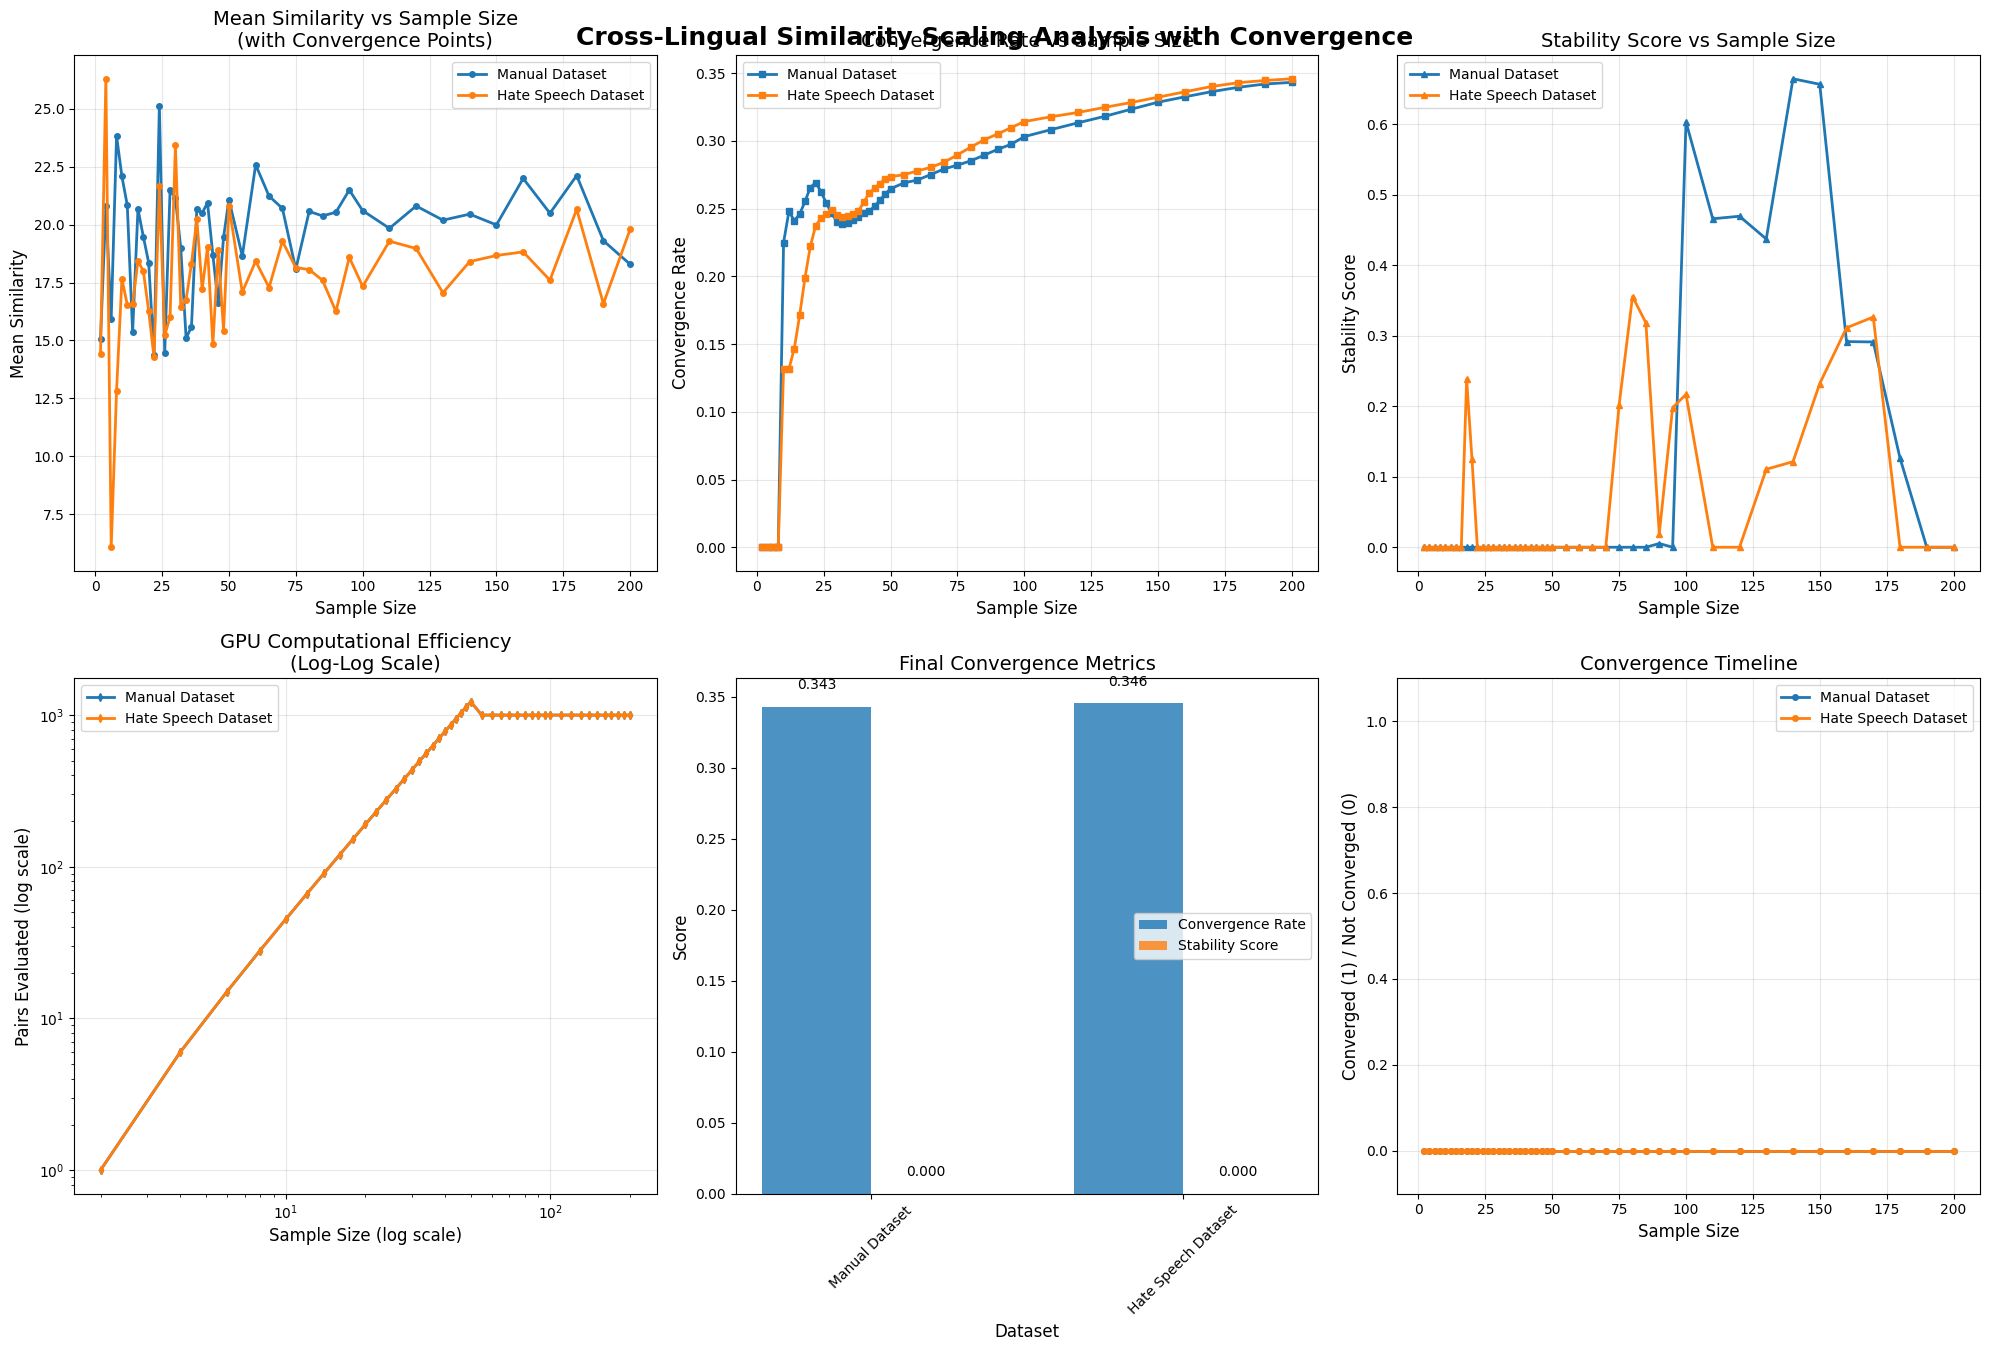


💾 Saving enhanced results...
❌ Error during analysis: Object of type bool is not JSON serializable

🧹 GPU cache cleared


Traceback (most recent call last):
  File "/tmp/ipython-input-209891481.py", line 5, in <cell line: 0>
    run_comprehensive_analysis()
  File "/tmp/ipython-input-3106456604.py", line 60, in run_comprehensive_analysis
    json_path, excel_path = save_enhanced_results(
                            ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-963781918.py", line 51, in save_enhanced_results
    json.dump(json_data, f, indent=2, ensure_ascii=False)
  File "/usr/lib/python3.12/json/__init__.py", line 179, in dump
    for chunk in iterable:
                 ^^^^^^^^
  File "/usr/lib/python3.12/json/encoder.py", line 432, in _iterencode
    yield from _iterencode_dict(o, _current_indent_level)
  File "/usr/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  File "/usr/lib/python3.12/json/encoder.py", line 406, in _iterencode_dict
    yield from chunks
  Fil

In [ ]:
# Main execution
if __name__ == "__main__":
    try:
        # Run comprehensive analysis
        run_comprehensive_analysis()

        # Demonstrate single similarity
        demonstrate_single_similarity()

    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        import traceback
        traceback.print_exc()

    finally:
        # Clear GPU cache
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print("\n🧹 GPU cache cleared")